In [1]:
import os
os.chdir("..")

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any
from collections import Counter
import itertools
import urllib

In [3]:
with open("data/task_6-2/training_set_clean_only_text.txt", "r") as f:
    examples = f.readlines()

with open("data/task_6-2/training_set_clean_only_tags.txt", "r") as f:
    labels = f.readlines()

In [4]:
df = pd.DataFrame({"text": examples, "label": labels})

In [5]:
df.head(10)

,text,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0\n
1,@anonymized_account @anonymized_account Brawo ...,0\n
2,"@anonymized_account @anonymized_account Super,...",0\n
3,@anonymized_account @anonymized_account Musi. ...,0\n
4,"Odrzut natychmiastowy, kwaśna mina, mam problem\n",0\n
5,"Jaki on był fajny xdd pamiętam, że spóźniłam s...",0\n
6,@anonymized_account No nie ma u nas szczęścia 😉\n,0\n
7,@anonymized_account Dawno kogoś tak wrednego n...,0\n
8,@anonymized_account @anonymized_account Zaległ...,0\n
9,@anonymized_account @anonymized_account @anony...,2\n


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10041 entries, 0 to 10040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10041 non-null  object
 1   label   10041 non-null  object
dtypes: object(2)
memory usage: 157.0+ KB


In [7]:
df["label"] = df["label"].apply(lambda x: x.replace("\n", ""))
df["label"] = df["label"].astype(int)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10041 entries, 0 to 10040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10041 non-null  object
 1   label   10041 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 157.0+ KB


# Exploratory data analysis

## Class distribution

In [9]:
class_distribution = df["label"].value_counts(normalize=True)

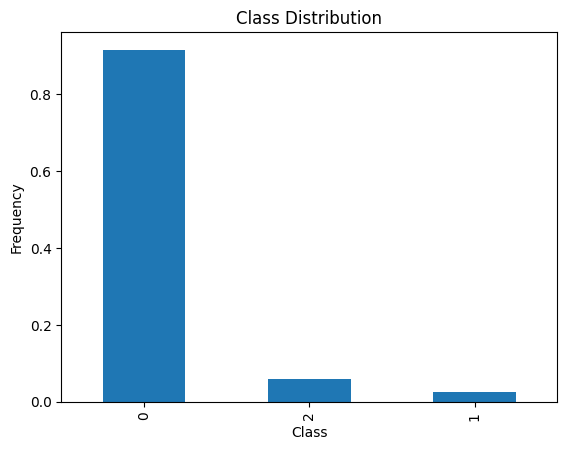

In [10]:
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

We can see that "1" and "2" classes are strongly undersampled.

## Top K words in each class

In [23]:
df["text"] = df["text"].apply(lambda x: x.replace("\n", ""))
df["text"] = df["text"].apply(lambda x: x.lower())

In [24]:
def get_top_k_words_in_class(
    dataframe: pd.DataFrame,
    class_label: int,
    k: int = 10,
    target_name: str = "label",
    input_name: str = "text",
) -> Dict[str, int]:
    class_examples = dataframe.loc[dataframe[target_name] == class_label][input_name].tolist()
    class_examples = [example.split(" ") for example in class_examples]
    class_examples = list(itertools.chain.from_iterable(class_examples))
    total_number_of_words = len(class_examples)
    word_counter = Counter(class_examples)
    word_counter = list(word_counter.items())
    word_counter_normalized = [(item[0], round(item[1]/total_number_of_words, 4)) for item in word_counter]
    word_counter_normalized = sorted(word_counter_normalized, key=lambda x:x[1], reverse=True)
    word_counter_normalized = word_counter_normalized[:k]
    return dict(word_counter_normalized)

In [25]:
top_k_words_for_each_class = {
    i: get_top_k_words_in_class(df, i, k=15)
    for i in set(df["label"].values)
}

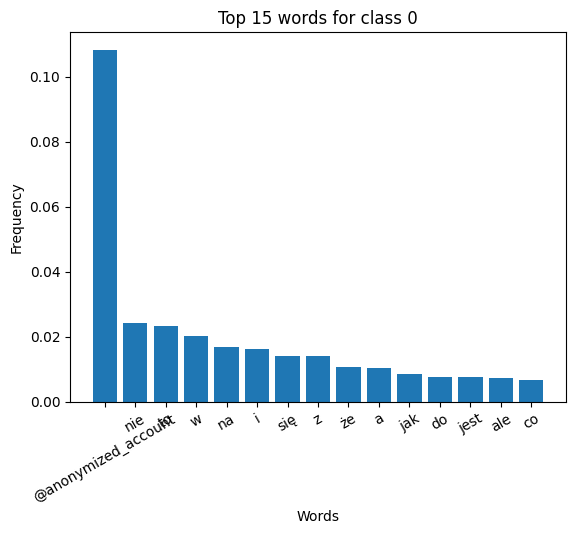

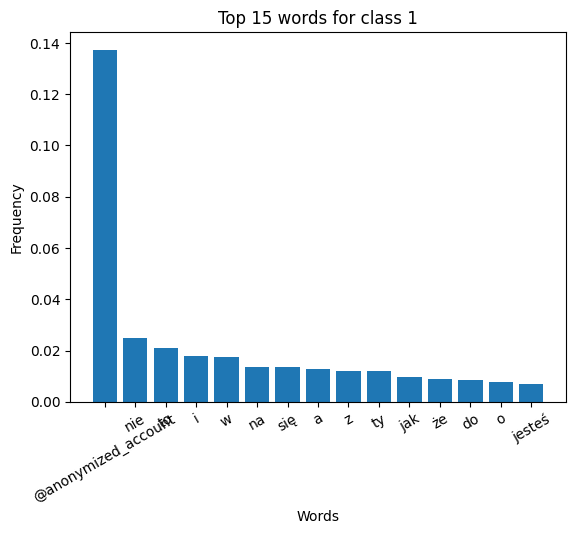

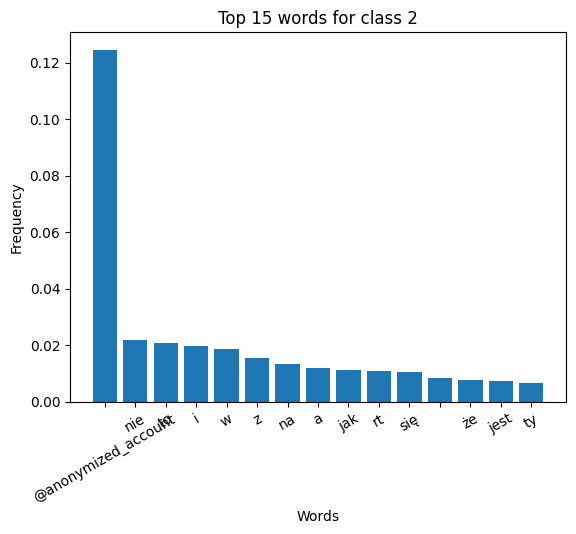

In [44]:
for i in top_k_words_for_each_class.keys():
    word_counts = top_k_words_for_each_class[i]
    plt.bar(range(len(word_counts)), list(word_counts.values()), align='center')
    plt.xticks(range(len(word_counts)), list(word_counts.keys()), rotation=30)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 15 words for class {i}')
    plt.show()

Based on these plots, we can spot several things:
- @anonymized_account token, which stands for mentioning a user, is a top occuring token in every class, so we can safely remove it in the preprocessing phase;
- a lot of top occuring words are common for all classes, so we can consider them stop-words and safely remove them from the corpus;
- a "jesteś" word is frequent in the "1" class, which stands for a harmful action addressed towards a private person.

## Average Tweet number of words in each class

In [39]:
def get_average_tweet_length_for_a_class(
    dataframe: pd.DataFrame,
    class_label: int,
    target_name: str = "label",
    input_name: str = "text",
) -> float:
    tweets_from_specifed_class = dataframe.loc[dataframe[target_name] == class_label]["text"]
    lengths = tweets_from_specifed_class.apply(lambda x: len(x.split(" ")))
    return round(lengths.mean(), 3)

In [41]:
average_tweet_lengths = {
    i: get_average_tweet_length_for_a_class(df, i)
    for i in set(df["label"].values)
}

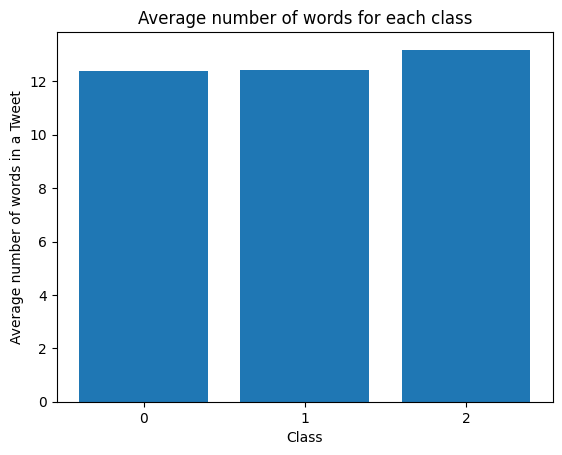

In [47]:
plt.bar(range(len(average_tweet_lengths)), list(average_tweet_lengths.values()), align="center")
plt.xticks(range(len(average_tweet_lengths)), list(average_tweet_lengths.keys()))
plt.xlabel('Class')
plt.ylabel('Average number of words in a Tweet')
plt.title(f'Average number of words for each class')
plt.show()

In [48]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.6 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.9/293.9 kB 7.0 MB/s eta 0:00:000:00:01


In [51]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariuszkossakowski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Stop words analysis

In [66]:
# downloading a list of common stopwords in Polish language
stopwords = pd.read_csv("https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt")
stopwords = stopwords["a"].values.tolist()

In [68]:
additional_stopwords_sets = [
    set(top_k_words_for_each_class[i].keys())
    for i in top_k_words_for_each_class.keys()
]

In [70]:
additional_stopwords = additional_stopwords_sets[0] & additional_stopwords_sets[1] & additional_stopwords_sets[2]

In [74]:
for word in additional_stopwords:
    if word.startswith("@") == False and word not in stopwords:
        stopwords.append(word)
        print(f"Appended {word}")

Appended a


So the list of common stop words already contains the most important ones in majority :)

In [75]:
stopwords

['aby',
 'ach',
 'acz',
 'aczkolwiek',
 'aj',
 'albo',
 'ale',
 'alez',
 'ależ',
 'ani',
 'az',
 'aż',
 'bardziej',
 'bardzo',
 'beda',
 'bedzie',
 'bez',
 'deda',
 'będą',
 'bede',
 'będę',
 'będzie',
 'bo',
 'bowiem',
 'by',
 'byc',
 'być',
 'byl',
 'byla',
 'byli',
 'bylo',
 'byly',
 'był',
 'była',
 'było',
 'były',
 'bynajmniej',
 'cala',
 'cali',
 'caly',
 'cała',
 'cały',
 'ci',
 'cie',
 'ciebie',
 'cię',
 'co',
 'cokolwiek',
 'cos',
 'coś',
 'czasami',
 'czasem',
 'czemu',
 'czy',
 'czyli',
 'daleko',
 'dla',
 'dlaczego',
 'dlatego',
 'do',
 'dobrze',
 'dokad',
 'dokąd',
 'dosc',
 'dość',
 'duzo',
 'dużo',
 'dwa',
 'dwaj',
 'dwie',
 'dwoje',
 'dzis',
 'dzisiaj',
 'dziś',
 'gdy',
 'gdyby',
 'gdyz',
 'gdyż',
 'gdzie',
 'gdziekolwiek',
 'gdzies',
 'gdzieś',
 'go',
 'i',
 'ich',
 'ile',
 'im',
 'inna',
 'inne',
 'inny',
 'innych',
 'iz',
 'iż',
 'ja',
 'jak',
 'jakas',
 'jakaś',
 'jakby',
 'jaki',
 'jakichs',
 'jakichś',
 'jakie',
 'jakis',
 'jakiś',
 'jakiz',
 'jakiż',
 'jakkolwie